In [34]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [35]:
import tensorflow as tf

In [36]:
from tensorflow.keras import models,layers

In [37]:
import matplotlib.pyplot as plt

In [82]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5702 files belonging to 3 classes.


In [39]:
class_names=dataset.class_names
class_names

['Early Blight', 'Healthy', 'Late Blight']

In [40]:
len(dataset)

179

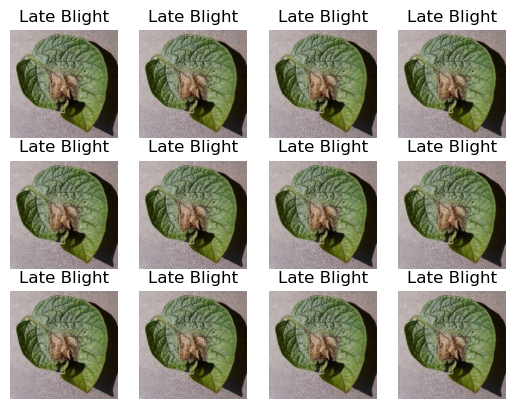

In [41]:
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
       ax=plt.subplot(3,4,i+1)
       plt.imshow(image_batch[0].numpy().astype("uint8"))
       plt.title(class_names[label_batch[0]])
       plt.axis("off")

In [42]:
len(dataset)

179

In [43]:
train_size=0.8
179*0.8


143.20000000000002

In [44]:
train_ds=dataset.take(143)
len(train_ds)

143

In [45]:
val_ds=dataset.take(18)

In [46]:
len(val_ds)

18

In [47]:
test_ds=dataset.skip(161)

In [48]:
len(test_ds)

18

In [49]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    test_size=int(test_split*ds_size)
    
    train_ds=ds.take(train_size)
    test_ds=ds.skip(train_size).take(test_size)
    val_ds=ds.skip(train_size).skip(test_size)
    return train_ds,val_ds,test_ds

In [50]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [51]:
len(train_ds)

143

In [52]:
len(test_ds)

17

In [53]:
len(val_ds)

19

In [54]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [55]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0,255)
])

In [56]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [58]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [59]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_42 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [60]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
    

In [61]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
143/143 [==============================] - 418s 3s/step - loss: 1.7318 - accuracy: 0.4376 - val_loss: 0.9825 - val_accuracy: 0.4794
Epoch 2/50
143/143 [==============================] - 360s 3s/step - loss: 0.7652 - accuracy: 0.6651 - val_loss: 0.5523 - val_accuracy: 0.7646
Epoch 3/50
143/143 [==============================] - 346s 2s/step - loss: 0.4914 - accuracy: 0.8068 - val_loss: 0.3501 - val_accuracy: 0.8660
Epoch 4/50
143/143 [==============================] - 331s 2s/step - loss: 0.3966 - accuracy: 0.8470 - val_loss: 0.2880 - val_accuracy: 0.8986
Epoch 5/50
143/143 [==============================] - 330s 2s/step - loss: 0.3949 - accuracy: 0.8466 - val_loss: 0.3350 - val_accuracy: 0.8625
Epoch 6/50
143/143 [==============================] - 324s 2s/step - loss: 0.3224 - accuracy: 0.8796 - val_loss: 0.3132 - val_accuracy: 0.8780
Epoch 7/50
143/143 [==============================] - 309s 2s/step - loss: 0.2767 - accuracy: 0.8978 - val_loss: 0.3650 - val_accuracy: 0.8608

In [73]:
scores=model.evaluate(test_ds)

17/17 [==============================] - 6s 367ms/step - loss: 0.1179 - accuracy: 0.9669


In [ ]:
scores

In [64]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
history.history['loss'][:5]

[1.7317814826965332]

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

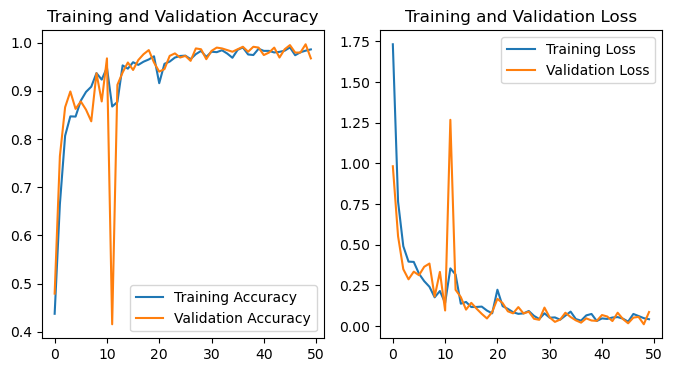

In [85]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [66]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [86]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


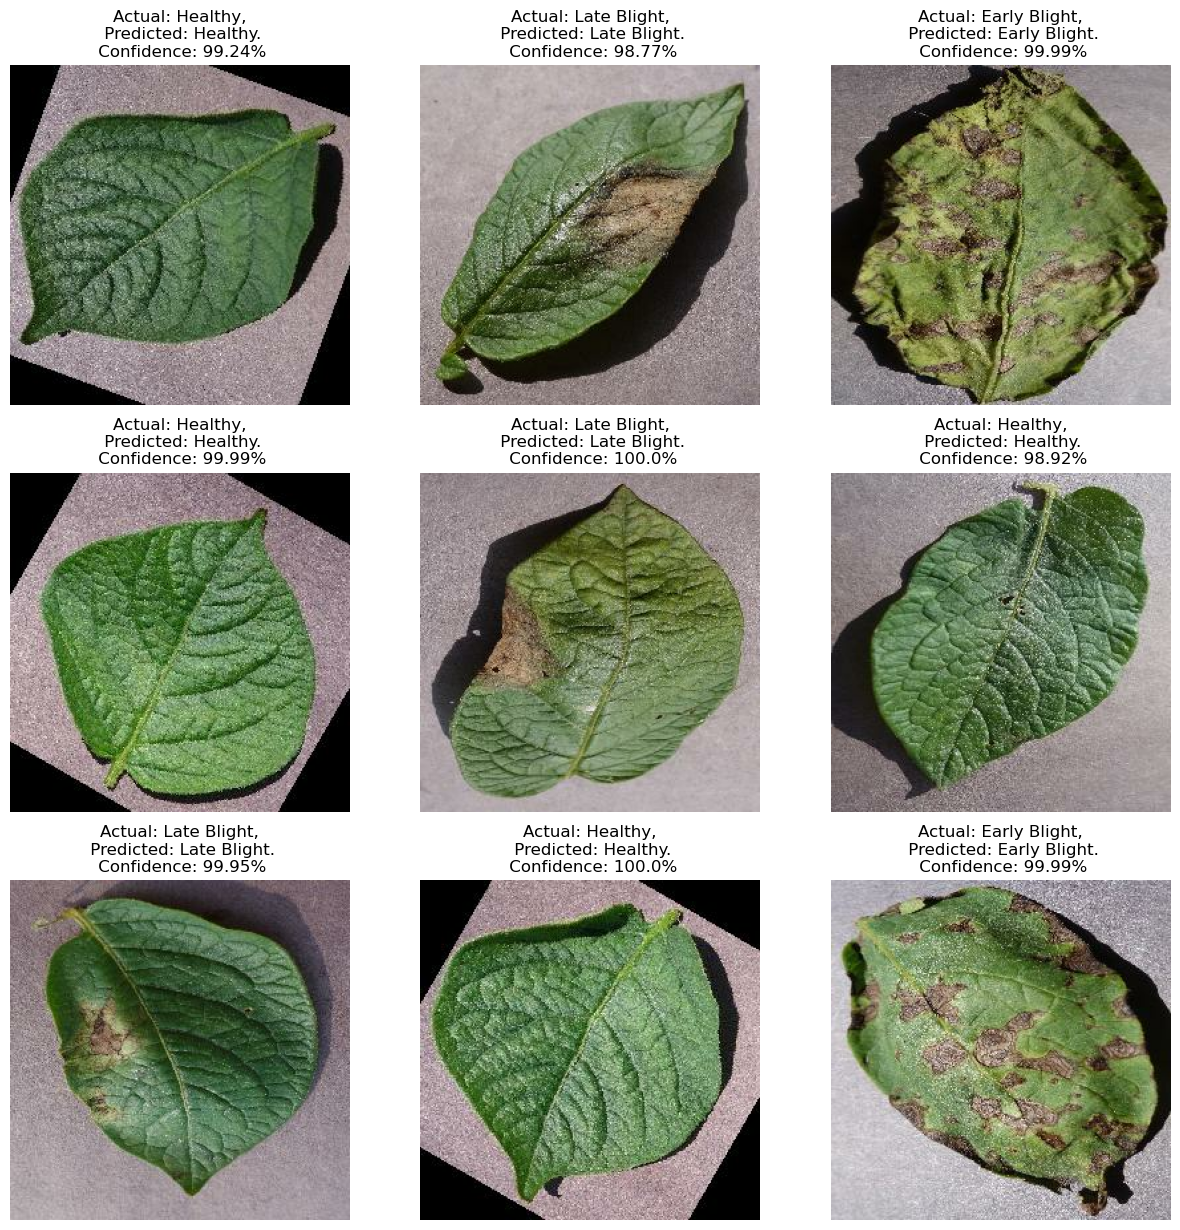

In [71]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [72]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [76]:
from tensorflow.keras.models import load_model

In [77]:
loaded_model=load_model("../models/1")

In [78]:
loaded_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                               